<a href="https://colab.research.google.com/github/SlavikHom/Learning/blob/main/FashionMNIST_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm
%matplotlib inline
from IPython import display
import pandas as pd

<ipython-input-1-396e4441eb54>:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


Подготовка данных

In [ ]:
TRAIN_BUF = 60000
BATCH_SIZE = 512
TEST_BUF = 10000
DIMS = (28,28,1)
N_TRAIN_BATCHES = int(TRAIN_BUF/BATCH_SIZE)
N_TEST_BATCHES = int(TEST_BUF/BATCH_SIZE)
(train_images, _), (test_images, _) = tf.keras.datasets.fashion_mnist.load_data()

4422102/4422102 [==============================] - 2s 0us/step


In [ ]:
train_images = train_images.reshape(train_images.shape[0],train_images.shape[1],train_images.shape[2],1).astype('float32')/255.0
train_images.shape

(60000, 28, 28, 1)

In [ ]:
train_images[0]

In [ ]:
test_images = test_images.reshape(test_images.shape[0], test_images.shape[1], test_images.shape[2],1).astype('float32')/255.0
test_images.shape

(10000, 28, 28, 1)

In [ ]:
train_dataset = (
  tf.data.Dataset.from_tensor_slices(train_images).shuffle(TRAIN_BUF).batch(BATCH_SIZE)
)
test_dataset = (
  tf.data.Dataset.from_tensor_slices(test_images).shuffle(TEST_BUF).batch(BATCH_SIZE)
)

Создаем модель

In [ ]:
class GAN(tf.keras.Model):
  def __init__(self,**kwargs):
    super(GAN, self).__init__()
    self.__dict__.update(kwargs)

    self.gen = tf.keras.Sequential(self.gen)
    self.disc = tf.keras.Sequential(self.disc)
  
  def generate(self,z):
    return self.gen(z)

  def discriminate(self,x):
    return self.disc(x)

  def compute_loss(self,x):  # рассчитываем ошибки (потери)
    z_samp = tf.random.normal([x.shape[0],1,1,self.n_Z]) # создаем шум
    x_gen = self.generate(z_samp) # пропускаем шум через генератор

    logits_x = self.discriminate(x) # пропускаем РЕАЛЬНОЕ изображение через дискриминатор
    logits_x_gen = self.discriminate(x_gen) # пропускаем ФЭЙКОВОЕ изображение через дискриминатор

    # считаем потери
    disc_real_loss = gan_loss(logits=logits_x, is_real=True)  # вызываем функцию которую создали в конце ячейки для подсчета потерь
    disc_fake_loss = gan_loss(logits=logits_x_gen, is_real=False) # вызываем функцию которую создали в конце ячейки для подсчета потерь
    disc_loss = disc_fake_loss + disc_real_loss

    gen_loss = gan_loss(logits=logits_x_gen, is_real=True)

    return disc_loss, gen_loss

  def compute_gradients(self,x): # рассчитываем градиенты
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      disc_loss, gen_loss = self.compute_loss(x) # ищем потери используя метод который сами создали выше

    gen_gradients = gen_tape.gradient(gen_loss, self.gen.trainable_variables)  # вычисляем градиенты
    disc_gradients = disc_tape.gradient(disc_loss, self.disc.trainable_variables) # вычисляем градиенты

    return gen_gradients, disc_gradients

  def apply_gradients(self, gen_gradients, disc_gradients):
    self.gen_optimizer.apply_gradients(
        zip(gen_gradients, self.gen.trainable_variables)
    )
    self.disc_optimizer.apply_gradients(
        zip(disc_gradients, self.disc.trainable_variables)
    )

  @tf.function
  def train(self, train_x):  # самый главный финальный метод для обучения - в нем вызываем два последних созданных нами метода
    gen_gradients, disc_gradients = self.compute_gradients(train_x)
    self.apply_gradients(gen_gradients, disc_gradients)


def gan_loss(logits, is_real = True):
  if is_real:
    labels = tf.ones_like(logits)
  else:
    labels = tf.zeros_like(logits)
  return tf.compat.v1.losses.sigmoid_cross_entropy(
      multi_class_labels=labels, logits=logits
  )

In [ ]:
N_Z = 64     # из 64 нам нужно получить  28 на 28 на 1
generator = [
    tf.keras.layers.Dense(3136), # 7*7*64
    tf.keras.layers.Reshape((7,7,64)),
    tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=3, strides=(2,2), padding = 'SAME', activation='relu'),
      tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=3, strides=(2,2), padding = 'SAME', activation='relu'),
    tf.keras.layers.Conv2DTranspose(filters=1, kernel_size=3, strides=(1,1), padding = 'SAME', activation='sigmoid'),

]
discriminator = [
    tf.keras.layers.InputLayer(input_shape=DIMS), # 28 28 1
    tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=(2,2),activation='relu'),
      tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=(2,2),activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1)
]

In [ ]:
example = tf.keras.Sequential(generator)
example.build((1,N_Z))
example.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (1, 3136)                 203840    
                                                                 
 reshape (Reshape)           (1, 7, 7, 64)             0         
                                                                 
 conv2d_transpose (Conv2DTra  (1, 14, 14, 64)          36928     
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (1, 28, 28, 64)          36928     
 ranspose)                                                       
                                                                 
 conv2d_transpose_2 (Conv2DT  (1, 28, 28, 1)           577       
 ranspose)                                                       
                                                        

In [ ]:
example = tf.keras.Sequential(discriminator)
example.build()
example.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 13, 13, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 6, 6, 64)          18496     
                                                                 
 flatten (Flatten)           (None, 2304)              0         
                                                                 
 dense_1 (Dense)             (None, 1)                 2305      
                                                                 
Total params: 21,121
Trainable params: 21,121
Non-trainable params: 0
_________________________________________________________________


In [ ]:
gen_optimizer = tf.keras.optimizers.Adam(0.001, beta_1=0.5)
disc_optimizer = tf.keras.optimizers.RMSprop(0.005)
model = GAN(gen=generator, disc=discriminator, gen_optimizer=gen_optimizer, disc_optimizer=disc_optimizer,n_Z = N_Z)

In [ ]:
def plot(model, epoch, nex=8, zm=2):
  samples = model.generate(tf.random.normal(shape=(BATCH_SIZE,N_Z)))
  fig, axs = plt.subplots(ncols=nex, nrows=1, figsize=(zm*nex,zm))
  for axi in range(nex):
    axs[axi].matshow(samples.numpy()[axi].squeeze(), cmap=plt.cm.Greys, vmin=0, vmax=1)
    axs[axi].axis('off')
  plt.savefig(f'{str(epoch)}-image.png')
  plt.show()

In [ ]:
losses = pd.DataFrame(columns=['disc_loss','gen_loss'])

epoch: 99, disc_loss 0.9856421947479248,gen_loss 1.797510027885437


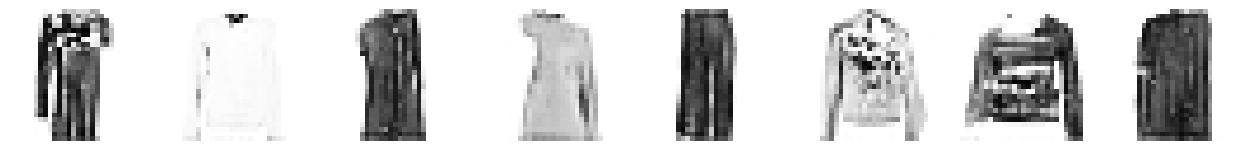

In [ ]:
n_epochs=100
for epoch in range(n_epochs):
  for batch, train_x in tqdm(zip(range(N_TRAIN_BATCHES), train_dataset), total=N_TRAIN_BATCHES):
    model.train(train_x)
  
  loss = []
  for batch, test_x in tqdm(zip(range(N_TEST_BATCHES), test_dataset), total=N_TEST_BATCHES):
    loss.append(model.compute_loss(train_x))
  losses.loc[len(losses)] = np.mean(loss, axis=0)

  display.clear_output()
  print(f'epoch: {epoch}, disc_loss {losses.disc_loss.values[-1]},gen_loss {losses.gen_loss.values[-1]}')
  plot(model, epoch)